# 01. Exploratory Data Analysis & Preprocessing
## Smart Wafer Yield Optimization Project

This notebook performs comprehensive exploratory data analysis (EDA) and data preprocessing for the SECOM semiconductor manufacturing dataset.

### Objectives:
- Load and explore the SECOM dataset (1567 samples, 591 features)
- Analyze missing value patterns and data quality
- Perform statistical analysis and visualization
- Clean and preprocess data for machine learning
- Save cleaned dataset for downstream analysis

### Dataset Information:
- **Source**: UCI ML Repository - SECOM Dataset
- **Samples**: 1,567 wafers
- **Features**: 591 sensor measurements and process parameters
- **Target**: Binary classification (–1: pass and 1: fail)
- **Challenge**: High missing value rate (41951/924530 (4.54%) missing values)

---

#### Why SECOM dataset has so many missing values?
The SECOM dataset contains a large number of missing values primarily due to the nature of semiconductor manufacturing processes. Several factors contribute to this:
  1. **Sensor Failures**: Thousands of sensors used across processes like deposition, etching, and lithography, some may malfunction or fail, leading to gaps in data collection.
  2. **Process Variability**: Different wafers may go through different processing steps, resulting in some sensors not being applicable or used for certain wafers.
  3. **Data Logging Issues**: There may be issues in data logging systems that lead to incomplete records.
  4. **Intentional Omissions**: Some data points may be intentionally left out if they are being recalibrated, deemed irrelevant or redundant for specific wafers.
  5. **Complex Manufacturing Environment**: The complexity and scale of semiconductor manufacturing can lead to inconsistencies in data collection.

In [1]:
# Import required libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Import our utility functions
import sys
import os
notebook_path = os.path.abspath("")
if notebook_path.endswith("notebooks"):
    project_root = os.path.dirname(notebook_path)
    os.chdir(project_root)
from app.utils import load_data, preprocess_data, get_data_summary

pd.set_option('display.width', 300)
# pd.set_option('display.max_rows', None)

print("Libraries imported successfully!")
print("Ready to begin EDA and preprocessing...")
print(f"Working directory set to: {os.getcwd()}")

Libraries imported successfully!
Ready to begin EDA and preprocessing...
Working directory set to: c:\Users\KarMing\Documents\wafer-yield


## 1. Data Loading and Initial Exploration


In [2]:
# Load the SECOM dataset
data = load_data()

# Display basic information
print(f"\nDataset shape: {data.shape}")
print(f"Memory usage: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nData types:")
print(data.dtypes.value_counts())

# Temporary drop timestamp column
if 'timestamp' in data.columns:
    data_timestamp = data['timestamp']
    data = data.drop(columns=['timestamp'])

# Display first few rows
print(f"\nFirst 5 rows:")
data.head()



= Loading raw SECOM data...

Dataset shape: (1567, 592)
Memory usage: 7.17 MB

Data types:
float64    590
int64        1
object       1
Name: count, dtype: int64

First 5 rows:


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_581,feature_582,feature_583,feature_584,feature_585,feature_586,feature_587,feature_588,feature_589,target
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [3]:
# Get comprehensive data summary
# Q: Why?
# A: To quickly profile the dataset before deeper EDA.
summary = get_data_summary(data)
print("= Dataset Summary:")
for key, value in summary.items():
    print(f"> {key}: {value}")

# Check for target variable
if 'target' in data.columns:
    print(f"\nTarget variable distribution:")
    print(data['target'].value_counts())
    print(f"Class balance ratio: {summary.get('class_balance', 'N/A'):.3f}")
else:
    print("\nNo target variable found in dataset")

# Q: Why is class imbalance a problem in yield prediction?
# A: Because models might learn to always predict the majority class (–1: pass). This inflates accuracy but fails to detect rare failures — which are the most costly for Micron.

= Dataset Summary:
> n_samples: 1567
> n_features: 590
> missing_values: 41951
> missing_percentage: 4.5298710610227655
> target_distribution: {-1: 1463, 1: 104}
> class_balance: 0.0710868079289132

Target variable distribution:
target
-1    1463
 1     104
Name: count, dtype: int64
Class balance ratio: 0.071


Limitations / missing pieces to consider

- No hyperparameter tuning / nested CV; the RF uses fixed n_estimators=200.
- No calibration / threshold selection / confusion matrices or class‑specific metrics beyond averaged precision/recall/f1.
- Mapping y → {0,1} is fine for modeling but if downstream code expects -1/1 you must keep track of the mapping.
- If you want per‑class metrics (precision_recall_fscore_support) or PR curve for the minority class, add those.
- SMOTE is used with default params — consider tuning k_neighbors or trying other resamplers (ADASYN, borderline‑SMOTE) and compare with undersampling/ensemble methods.
- For rigorous comparison use nested CV or a repeated stratified CV and record training vs test scores to check overfitting.

## 2. Missing Value Analysis

- SECOM dataset is known for having many missing values. Let's analyze the missing value patterns to understand the data quality issues.
- If features are Missing Completely At Random (MCAR), we can impute safely.
- If missingness is systematic (like certain sensors always missing), that’s Missing Not At Random (MNAR) — a process issue worth flagging to engineers.

#### > What if high percentages of a sensor’s readings are missing?
Drop that feature — it doesn’t contribute meaningful information. The model may overfit to imputed noise.

#### > Why is it important to analyze missing values?
Analyzing missing values is crucial because:
1. **Data Quality**: High rates of missing data can indicate issues with data collection processes
2. **Bias**: Missing data can introduce bias if the missingness is not random, affecting model performance.
3. **Imputation Strategies**: Understanding the pattern of missingness helps in choosing appropriate imputation methods.
4. **Feature Selection**: Features with excessive missing values may need to be excluded from analysis.

In [4]:
# Calculate missing value statistics
features = [col for col in data.columns if col != 'target']
data_features = data[features]

missing_stats = data_features.isnull().sum()
missing_percentage = (missing_stats / len(data_features)) * 100

# Create missing value summary
missing_summary = pd.DataFrame({
    'Feature': missing_stats.index,
    'Missing_Count': missing_stats.values,
    'Missing_Percentage': missing_percentage.values
}).sort_values('Missing_Percentage', ascending=False)

print("Missing Value Analysis:")
print(f"Total missing values: {data_features.isnull().sum().sum():,}")
print(f"Percentage of missing data: {(data_features.isnull().sum().sum() / (data_features.shape[0] * data_features.shape[1])) * 100:.2f}%")
print(f"\nFeatures with no missing values: {len(missing_summary[missing_summary['Missing_Percentage'] == 0])}")
print(f"Features with >0% missing values: {len(missing_summary[missing_summary['Missing_Percentage'] != 0])}")
print(f"Features with >15% missing values: {len(missing_summary[missing_summary['Missing_Percentage'] > 15])}")
print(f"Features with >50% missing values: {len(missing_summary[missing_summary['Missing_Percentage'] > 50])}")
print(f"Features with >80% missing values: {len(missing_summary[missing_summary['Missing_Percentage'] > 80])}")

# Display top 20 features with most missing values
print(f"\nTop 20 features with most missing values:")
missing_summary.head(20)

Missing Value Analysis:
Total missing values: 41,951
Percentage of missing data: 4.54%

Features with no missing values: 52
Features with >0% missing values: 538
Features with >15% missing values: 52
Features with >50% missing values: 28
Features with >80% missing values: 8

Top 20 features with most missing values:


,Feature,Missing_Count,Missing_Percentage
292,feature_292,1429,91.193363
293,feature_293,1429,91.193363
158,feature_158,1429,91.193363
157,feature_157,1429,91.193363
492,feature_492,1341,85.577537
85,feature_85,1341,85.577537
358,feature_358,1341,85.577537
220,feature_220,1341,85.577537
244,feature_244,1018,64.964901
517,feature_517,1018,64.964901


In [5]:
# Create 3x1 interactive subplot grid
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=(
        'Distribution of Missing Values Across Features',
        'Top 30 Features with Most Missing Values',
        'Cumulative Histogram of Missing Percentages',
    ),
    horizontal_spacing=0.12,
    vertical_spacing=0.1
)

# 1. Missing value distribution
fig.add_trace(
    go.Histogram(
        x=missing_percentage,
        nbinsx=100,
        marker_color='skyblue',
        opacity=0.7,
        name='Missing %',
        hovertemplate='Missing %: <b>%{x:.2f}</b><br>Feature Count: %{y}<extra></extra>'
    ),
    row=1, col=1
)
fig.add_vline(x=15, line_dash='dash', line_color='red', annotation_text='15% threshold', row=1, col=1)
fig.add_vline(x=50, line_dash='dash', line_color='red', annotation_text='50% threshold', row=1, col=1)
fig.add_vline(x=80, line_dash='dash', line_color='red', annotation_text='80% threshold', row=1, col=1)

# 2️. Top 30 features with most missing values
top_missing = missing_summary.head(30)
fig.add_trace(
    go.Bar(
        y=top_missing['Missing_Percentage'],
        x=top_missing['Feature'],
        marker_color='coral',
        name='Top Missing Features',
        hovertemplate='Feature: <b>%{x}</b><br>Missing %: %{y:.2f}<extra></extra>'
    ),
    row=2, col=1
)

# 3️. Cumulative histogram of missing percentages
fig.add_trace(
    go.Histogram(
        x=missing_percentage,
        # nbinsx=100,
        marker_color='mediumseagreen',
        marker=dict(
            color='mediumseagreen',
            line=dict(
                color='black',  # outline color
                width=1          # outline thickness
            )
        ),
        opacity=0.7,
        cumulative_enabled=True,
        name='Cumulative Distribution',
        hovertemplate='Missing % ≤ %{x:.3f}<br>Cumulative Features: %{y}<extra></extra>'
    ),
    row=3, col=1
)

# Update layout for better aesthetics
fig.update_layout(
    title_text='Interactive Missing Value Analysis Dashboard',
    template='plotly_white',
    height=1500,
    width=1300,
    showlegend=False
)

# Update axes labels
fig.update_xaxes(title_text='Missing Percentage', row=1, col=1)
fig.update_yaxes(title_text='Number of Features', row=1, col=1)


fig.update_xaxes(title_text='Features', row=2, col=1)
fig.update_yaxes(title_text='Missing Percentage', row=2, col=1)

fig.update_xaxes(title_text='Missing Percentage', row=3, col=1)
fig.update_yaxes(title_text='Cumulative Features', row=3, col=1)
fig.update_yaxes(range=[500, 600], row=3, col=1)


fig.show()

target             -1         1
feature_292  0.911141  0.923077
feature_293  0.911141  0.923077
feature_158  0.911141  0.923077
feature_157  0.911141  0.923077
feature_492  0.853042  0.894231
feature_85   0.853042  0.894231
feature_358  0.853042  0.894231
feature_220  0.853042  0.894231
feature_244  0.645249  0.711538
feature_517  0.645249  0.711538
feature_109  0.645249  0.711538
feature_246  0.645249  0.711538
feature_383  0.645249  0.711538
feature_382  0.645249  0.711538
feature_384  0.645249  0.711538
feature_245  0.645249  0.711538
feature_111  0.645249  0.711538
feature_110  0.645249  0.711538
feature_516  0.645249  0.711538
feature_518  0.645249  0.711538
feature_580  0.608339  0.567308
feature_578  0.608339  0.567308
feature_579  0.608339  0.567308
feature_581  0.608339  0.567308
feature_73   0.518113  0.346154
feature_345  0.518113  0.346154
feature_72   0.518113  0.346154
feature_346  0.518113  0.346154
feature_519  0.466165  0.317308
feature_247  0.466165  0.317308


<Axes: >

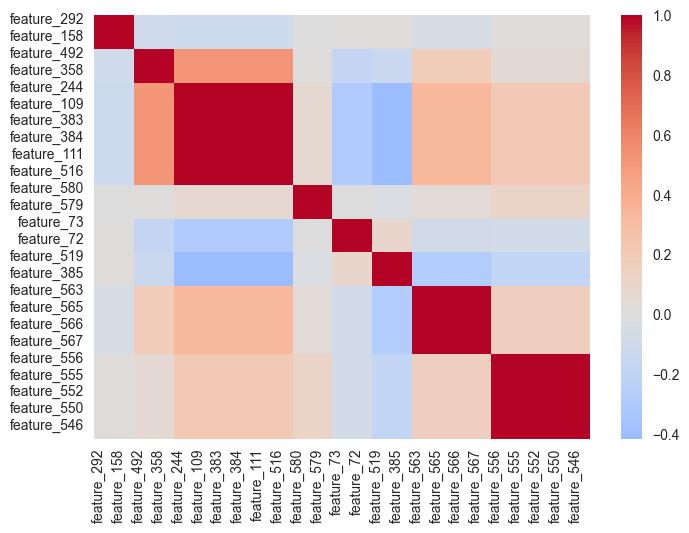

In [9]:
# quantify
miss_pct = data_features.isnull().mean().sort_values(ascending=False)

# per-class missingness (if target exists)
m = data.groupby('target').apply(lambda df: df.isnull().mean()).T
print(m.loc[miss_pct.head(30).index])

# missingness correlation / heatmap (top features)
top = miss_pct.index[:50].tolist()
sns.heatmap(data_features[top].isnull().corr(), cmap='coolwarm', center=0)

## 3. Statistical Analysis and Data Distribution

### > Isolate “complete” features (0% missing) to understand basic data behavior:
- Mean, variance, min, max
- Outliers via IQR (Interquartile Range)
- Histograms for sample features

### > .describe() is valuable because it helps to:
- Spot scale differences — e.g., one feature ranges between 0–1 while another is in the hundreds.
- Detect constant or near-constant features — if std = 0 or min = max, that feature has no variation and might be dropped.
- Identify potential measurement issues — e.g., negative values in sensors that should only output positives.
- Provide baseline statistics — for later normalization, scaling, or PCA.

### > Why check for outliers before normalization?
Because outliers can distort the scaling, especially with methods like MinMaxScaler. Consider using RobustScaler or log transformation if outliers are significant.

In [7]:
# Analyze data distributions for complete features
complete_features = missing_summary[missing_summary['Missing_Percentage'] == 0]['Feature'].tolist()
print(f"Number of complete features (0% missing): {len(complete_features)}")

if len(complete_features) > 0:
    # Statistical summary for complete features
    complete_data = data[complete_features]
    print(f"\nStatistical summary for complete features:")
    print(complete_data.describe())
    
    # Check for outliers using IQR method
    Q1 = complete_data.quantile(0.25)
    Q3 = complete_data.quantile(0.75)
    IQR = Q3 - Q1
    outlier_mask = ((complete_data < (Q1 - 1.5 * IQR)) | (complete_data > (Q3 + 1.5 * IQR))).any(axis=1)
    print(f"\nNumber of samples with outliers: {outlier_mask.sum()}")
    print(f"Percentage of samples with outliers: {outlier_mask.mean() * 100:.2f}%")
    ## Why use mean here? It is the same as:
    # If 1000 samples and 243 of them have at least one outlier:
    # outlier_mask.mean() = 1 + 1 + 1 ... (243 times) + 0 + 0 + ... (757 times) / 1000 = 0.243 ## Due to True values being 1, False being 0
    # outlier_mask.sum() = 243 
    # outlier_mask.mean() * 100 = 24.3%
else:
    print("No complete features found for statistical analysis")


Number of complete features (0% missing): 52

Statistical summary for complete features:
        feature_20  feature_571  feature_570  feature_573  feature_393  feature_429  feature_390  feature_392  feature_577  feature_574  ...  feature_114  feature_113  feature_527  feature_526  feature_524  feature_523  feature_522  feature_521  feature_520  feature_120
count  1567.000000  1567.000000  1567.000000  1567.000000  1567.000000  1567.000000  1567.000000  1567.000000  1567.000000  1567.000000  ...  1567.000000  1567.000000  1567.000000  1567.000000  1567.000000  1567.000000  1567.000000  1567.000000  1567.000000  1567.000000
mean      1.405054     2.101836   530.523623     0.345636     0.133990     4.171844     1.431868     0.004533    16.642363     9.162315  ...     0.000123     0.945424     6.395717     1.443457     5.687782     0.453896    14.728866    11.610080     2.695999     6.310863
std       0.016737     0.275112    17.499736     0.248478     0.038408     6.435390    20.326415  

In [8]:
# # Visualize distributions for a sample of features
# if len(complete_features) > 0:
#     # Select a sample of complete features for visualization
#     sample_features = complete_features[:12] if len(complete_features) >= 12 else complete_features
    
#     fig, axes = plt.subplots(3, 4, figsize=(16, 12))
#     axes = axes.flatten()
    
#     for i, feature in enumerate(sample_features):
#         if i < len(axes):
#             # Histogram
#             axes[i].hist(data[feature].dropna(), bins=30, alpha=0.7, color='lightblue', edgecolor='black')
#             axes[i].set_title(f'{feature}')
#             axes[i].set_xlabel('Value')
#             axes[i].set_ylabel('Frequency')
#             axes[i].grid(True, alpha=0.3)
    
#     # Hide unused subplots
#     for i in range(len(sample_features), len(axes)):
#         axes[i].set_visible(False)
    
#     plt.suptitle('Distribution of Complete Features', fontsize=16, y=0.98)
#     plt.tight_layout()
#     plt.show()
# else:
#     print("No complete features available for distribution visualization")


In [9]:
# Visualize distributions for a sample of features
if len(complete_features) > 0:
    # Select up to 16 features for visualization
    sample_features = complete_features[:16] if len(complete_features) >= 16 else complete_features

    # Create a 4x4 grid of subplots
    fig = make_subplots(
        rows=4,
        cols=4,
        subplot_titles=sample_features,
        horizontal_spacing=0.08,
        vertical_spacing=0.10
    )
    
    for i, feature in enumerate(sample_features):
        row = i // 4 + 1
        col = i % 4 + 1
        
        # Add histogram for each feature
        fig.add_trace(
            go.Histogram(
                x=data[feature].dropna(),
                nbinsx=30,
                marker=dict(color='lightblue', line=dict(color='black', width=1)),
                opacity=0.75,
                name=feature
            ),
            row=row, col=col
        )
        
        # Set axis labels for each subplot
        fig.update_xaxes(title_text="Value", row=row, col=col)
        fig.update_yaxes(title_text="Frequency", row=row, col=col)
    
    # Update overall layout
    fig.update_layout(
        title_text="Distribution of Complete Features (Interactive)",
        showlegend=False,
        height=900,
        width=1400,
        title_x=0.5,
        template='plotly_white'
    )
    
    # Optional: light grid lines for clarity
    fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgray')
    fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgray')

    fig.show()

else:
    print("No complete features available for distribution visualization")


| **Pattern**                                        | **What It Means (in SECOM context)**                                                                               | **Potential Action / Usefulness**                                                                |
| -------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------ |
| **Normal (bell-shaped)**                           | Sensor readings cluster around a mean value, symmetric distribution.                                               | Likely stable and well-calibrated sensor. Baseline process behavior.                             |
| **Right-skewed (long tail to the right)**          | Most readings are low, few high spikes. Could indicate occasional high sensor readings (e.g., temperature spikes). | Investigate what causes spikes. Check if spikes correspond to defective samples.                 |
| **Left-skewed (long tail to the left)**            | Most readings are high, few low outliers.                                                                          | Could suggest low outliers (dropouts, low voltage, etc.). Check correlation with quality issues. |
| **Bimodal / Multimodal (two or more peaks)**       | Sensor shows two different operating regimes (e.g., two production lines, machines, shifts, or process modes).                       | Could mean process inconsistency. Important to model separately or add categorical indicator.    |
| **Flat / Uniform**                                 | Values spread roughly evenly across range.                                                                         | Feature might not have a strong relationship with output; could be noise.                        |
| **Very narrow spike (little variance)**            | All readings nearly identical.                                                                                     | Low variance → feature may be redundant or useless for modeling (drop it).                       |
| **Outliers (isolated bins far from main cluster)** | Unusual readings far from majority.                                                                                | Possible sensor faults, measurement errors, or rare events worth investigating.                  |


In [10]:
# Analyze data distributions for all features and focus on outliers impacting yield
# > Step 1: For each feature, compare the failure rate among outlier samples vs non-outlier samples.
# If fail rate is significantly higher (or lower) in outliers, then outliers carry signal and should be treated carefully.
# If fail rates are similar, outliers are likely noise/neutral — safe to cap or transform.

Q1 = data_features.quantile(0.25)
Q3 = data_features.quantile(0.75)
IQR = Q3 - Q1

outliers_df = (data_features < (Q1 - 1.5 * IQR)) | (data_features > (Q3 + 1.5 * IQR))

comparison_results = []

for feature in data_features.columns:
    outlier_mask = outliers_df[feature]
    
    if outlier_mask.sum() == 0:
        # No outliers for this feature, skip or mark as neutral
        continue
    
    # Fail rate among outliers
    fail_rate_outliers = data.loc[outlier_mask, 'target'].eq(1).mean()
    # Fail rate among non-outliers
    fail_rate_non_outliers = data.loc[~outlier_mask, 'target'].eq(1).mean()
    
    comparison_results.append({
        'Feature': feature,
        'Fail_Rate_Outliers': fail_rate_outliers,
        'Fail_Rate_Non_Outliers': fail_rate_non_outliers,
        'Outlier_Count': outlier_mask.sum(),
        'Non_Outlier_Count': (~outlier_mask).sum(),
        'Fail_Rate_Difference': fail_rate_outliers - fail_rate_non_outliers
    })

comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.sort_values(by='Fail_Rate_Difference', ascending=False)

print("Outlier Impact on Failure Rates by Feature:")
print(comparison_df.head(100))

# However we try to take into account the Outlier_Count as well when interpreting the results:
# We want those with high Outlier_Count and high Fail_Rate_Difference to be more reliable indicators.
high_outlier_count_threshold = data.shape[0] * 0.05  # e.g., at least 5% of samples are outliers
print("\nFeatures with High Outlier Count and Significant Fail Rate Difference:")
reliable_indicators = comparison_df[
    (comparison_df['Outlier_Count'] >= high_outlier_count_threshold) &
    (comparison_df['Fail_Rate_Difference'] >= 0.05)  # e.g., at least 5% difference
]
print(f"Number of reliable indicators found: {len(reliable_indicators)}")
print(reliable_indicators.head(20))

# > Step 2: Interpretation
# Fail_Rate_Difference >> 0: outliers are enriched for failures → do not neutralize, they carry predictive info.
# Fail_Rate_Difference ≈ 0: outliers have no impact on fail rate → can consider neutralizing (e.g., clipping or winsorizing).
# Fail_Rate_Difference < 0: outliers might even have lower fail rate → maybe worth investigating further.


## <To Study> 
## Extract the correlations between features that have high outlier fail rate differences
## to see if they cluster into groups indicating specific failure modes

Outlier Impact on Failure Rates by Feature:
         Feature  Fail_Rate_Outliers  Fail_Rate_Non_Outliers  Outlier_Count  Non_Outlier_Count  Fail_Rate_Difference
48    feature_55            0.400000                0.065301              5               1562              0.334699
423  feature_561            0.333333                0.064827              9               1558              0.268507
57    feature_64            0.287879                0.056629             66               1501              0.231250
386  feature_493            0.285714                0.065385              7               1560              0.220330
198  feature_221            0.285714                0.065385              7               1560              0.220330
..           ...                 ...                     ...            ...                ...                   ...
15    feature_17            0.125000                0.065764             16               1551              0.059236
62    feature_70    

| Scenario                                             | Action or Interpretation                                                                                                                                 |
| ---------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Low Outlier_Count + Very High Fail_Rate_Outliers** | Strong potential signal, but be cautious. Consider verifying with more data or cross-validation. Keep the feature but treat it as less reliable. |
| **High Outlier_Count + High Fail_Rate_Outliers**     | Strong and statistically more reliable signal. Definitely useful for modeling.                                                                           |
| **Low Outlier_Count + Low Fail_Rate_Outliers**       | Probably noise or irrelevant outliers, can ignore.                                                                                                       |
| **High Outlier_Count + Low Fail_Rate_Outliers**      | Outliers not informative for failure; can ignore or treat as normal.                                                                                     |


In [11]:
top_features = comparison_df.head(30) # top 30 features where outliers differ most in fail rate

fig = go.Figure()

fig.add_trace(go.Bar(
    x=top_features['Feature'],
    y=top_features['Fail_Rate_Outliers'],
    name='Fail Rate (Outliers)',
    marker_color='crimson',
    hovertemplate='Feature: %{x}<br>Fail Rate (Outliers): %{y:.2%}<extra></extra>'
))

fig.add_trace(go.Bar(
    x=top_features['Feature'],
    y=top_features['Fail_Rate_Non_Outliers'],
    name='Fail Rate (Non-Outliers)',
    marker_color='steelblue',
    hovertemplate='Feature: %{x}<br>Fail Rate (Non-Outliers): %{y:.2%}<extra></extra>'
))

fig.update_layout(
    title='Fail Rate Comparison: Outliers vs Non-Outliers (Top 30 Features)',
    xaxis_title='Feature',
    yaxis_title='Fail Rate',
    barmode='group',
    yaxis=dict(range=[0, 1]),
    template='plotly_white',
    height=500
)

fig.show()

#### Temporal Analysis - Process Drift Detection

Why this matters: Micron's smart manufacturing deals with process variation over time. This shows how to detect drift/jumps in sensor data over production time.

In [12]:
test_col = 6
print("Analyzing sensor drift patterns...")

if 'data_timestamp' in globals() or 'data_timestamp' in locals():
    ts = pd.to_datetime(data_timestamp)
    if len(ts) != len(data):
        print("Warning: timestamp length does not match data length — skipping temporal analysis.")
    else:
        if isinstance(complete_features, list) and len(complete_features) > 0:
            df_complete = data[complete_features].copy()
        else:
            raise ValueError("complete_features must be a non-empty list of column names")

        # concat the feature DataFrame with the timestamp Series
        df_ts = pd.concat([df_complete.reset_index(drop=True), ts.reset_index(drop=True).rename('timestamp')], axis=1)
        print(f"Number of rows in concatenated DataFrame: {df_ts.shape[0]}, columns: {df_ts.shape[1]}")

        # set timestamp index for time-based analysis
        df_ts['timestamp'] = pd.to_datetime(df_ts['timestamp'])
        df_ts = df_ts.set_index('timestamp').sort_index()

        # proceed with plotting / drift detection using df_ts
        sample_sensors = complete_features[:test_col] if len(complete_features) >= test_col else complete_features
        if len(sample_sensors) == 0:
            print("No complete features available for temporal analysis.")
        else:
            window = 50            # rolling window for trend estimation
            min_periods = 10       # minimum periods to compute rolling stats
            sigma_threshold = 3.0  # number of std deviations to call a jump

            jump_summary = []
            rows = int(np.ceil(len(sample_sensors) / 2))
            cols = 2 if len(sample_sensors) > 1 else 1

            # compute rolling stats and detect jumps
            for sensor in sample_sensors:
                series = df_ts[sensor].astype(float)
                rolling_mean = series.rolling(window=window, min_periods=min_periods).mean()
                rolling_std = series.rolling(window=window, min_periods=min_periods).std()
                jumps_mask = (series - rolling_mean).abs() > (sigma_threshold * rolling_std)
                jumps_mask = jumps_mask.fillna(False)
                total_jumps = int(jumps_mask.sum())
                pct_jumps = jumps_mask.mean() * 100 if len(jumps_mask) > 0 else 0.0

                jump_summary.append({
                    'sensor': sensor,
                    'jump_count': total_jumps,
                    'jump_pct': pct_jumps,
                    'rolling_window': window,
                    'sigma_threshold': sigma_threshold
                })

                print(f"{sensor}: {total_jumps} jumps detected ({pct_jumps:.2f}%) with window={window}, sigma={sigma_threshold}")

            jump_summary_df = pd.DataFrame(jump_summary).sort_values('jump_count', ascending=False)
            print("\nJump summary (top sensors):")
            display(jump_summary_df.head(20))

            # Plot: try Plotly first, fallback to Matplotlib if Plotly internals raise ModuleNotFoundError
            try:
                fig = make_subplots(rows=rows, cols=cols, subplot_titles=sample_sensors)
                for i, sensor in enumerate(sample_sensors):
                    series = df_ts[sensor].astype(float)
                    rolling_mean = series.rolling(window=window, min_periods=min_periods).mean()
                    rolling_std = series.rolling(window=window, min_periods=min_periods).std()
                    jumps_mask = (series - rolling_mean).abs() > (sigma_threshold * rolling_std)
                    jumps_mask = jumps_mask.fillna(False)
                    jump_times = series.index[jumps_mask]
                    jump_vals = series.loc[jump_times]

                    row = i // cols + 1
                    col = i % cols + 1

                    # basic traces (avoid complex 'line' validators where possible)
                    fig.add_trace(go.Scatter(x=series.index, y=series.values, mode='lines', name=f'{sensor} raw'), row=row, col=col)
                    fig.add_trace(go.Scatter(x=rolling_mean.index, y=rolling_mean.values, mode='lines', name=f'{sensor} rolling_mean',
                                             line=dict(dash='dash', width=2)), row=row, col=col)

                    if not jump_times.empty:
                        fig.add_trace(go.Scatter(x=jump_times, y=jump_vals.values, mode='markers',
                                                 marker=dict(color='red', size=6), name=f'{sensor} jumps'), row=row, col=col)

                fig.update_layout(title="Sensor Drift & Jump Markers (rolling mean/std)", height=300 * rows, template='plotly_white', showlegend=False)
                fig.show()

            except ModuleNotFoundError as e:
                # Fallback: Matplotlib static plots
                print(f"Plotly internals failed ({e}). Falling back to Matplotlib plotting.")
                import matplotlib.dates as mdates
                fig, axes = plt.subplots(rows, cols, figsize=(12 * cols, 3 * rows), squeeze=False)
                for i, sensor in enumerate(sample_sensors):
                    series = df_ts[sensor].astype(float)
                    rolling_mean = series.rolling(window=window, min_periods=min_periods).mean()
                    rolling_std = series.rolling(window=window, min_periods=min_periods).std()
                    jumps_mask = (series - rolling_mean).abs() > (sigma_threshold * rolling_std)
                    jumps_mask = jumps_mask.fillna(False)
                    jump_times = series.index[jumps_mask]
                    jump_vals = series.loc[jump_times]

                    r = i // cols
                    c = i % cols
                    ax = axes[r][c]
                    ax.plot(series.index, series.values, color='steelblue', linewidth=0.8)
                    ax.plot(rolling_mean.index, rolling_mean.values, color='orange', linestyle='--', linewidth=1.4)
                    if not jump_times.empty:
                        ax.scatter(jump_times, jump_vals.values, color='red', s=20, zorder=5)
                    ax.set_title(sensor)
                    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(mdates.AutoDateLocator()))
                    ax.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
else:
    print("No timestamp available (data_timestamp not set). Skipping temporal analysis.")

Analyzing sensor drift patterns...
Number of rows in concatenated DataFrame: 1567, columns: 53
feature_20: 14 jumps detected (0.89%) with window=50, sigma=3.0
feature_571: 18 jumps detected (1.15%) with window=50, sigma=3.0
feature_570: 49 jumps detected (3.13%) with window=50, sigma=3.0
feature_573: 53 jumps detected (3.38%) with window=50, sigma=3.0
feature_393: 7 jumps detected (0.45%) with window=50, sigma=3.0
feature_429: 24 jumps detected (1.53%) with window=50, sigma=3.0

Jump summary (top sensors):


,sensor,jump_count,jump_pct,rolling_window,sigma_threshold
3,feature_573,53,3.382259,50,3.0
2,feature_570,49,3.126994,50,3.0
5,feature_429,24,1.531589,50,3.0
1,feature_571,18,1.148692,50,3.0
0,feature_20,14,0.893427,50,3.0
4,feature_393,7,0.446713,50,3.0


## 4. Data Preprocessing

Now we'll clean and preprocess the data for machine learning. This includes:
- Handling missing values using appropriate imputation strategies
- Feature scaling and normalization
- Outlier treatment
- Saving the cleaned dataset


In [13]:
# Preprocess the data using our utility function
print("Starting data preprocessing...")
print("This may take a few minutes due to the large dataset size...")

# Use KNN imputation for missing values (most sophisticated approach)
processed_data = preprocess_data(data, method='knn')

print(f"\nPreprocessing completed!")
print(f"Original shape: {data.shape}")
print(f"Processed shape: {processed_data.shape}")
print(f"Missing values after preprocessing: {processed_data.isnull().sum().sum()}")


Starting data preprocessing...
This may take a few minutes due to the large dataset size...

= Preprocessing data using 'knn' imputation...
> Missing values before imputation (per feature):
feature_0       6
feature_1       7
feature_2      14
feature_3      14
feature_4      14
               ..
feature_585     1
feature_586     1
feature_587     1
feature_588     1
feature_589     1
Length: 590, dtype: int64
> Missing values before imputation (total): 41951/924530 (4.54%)
> Missing values after imputation (total): 0/924530 (0.00%)
> Preprocessed data saved to data/processed/secom_preprocessed_data.csv
> Shape: (1567, 591)
> Missing values: 0

Preprocessing completed!
Original shape: (1567, 591)
Processed shape: (1567, 591)
Missing values after preprocessing: 0


In [14]:
# Verify the preprocessing results
print("Verifying preprocessing results...")

# Check for any remaining missing values
remaining_missing = processed_data.isnull().sum().sum()
print(f"Remaining missing values: {remaining_missing}")

# Check target distribution (if available)
if 'target' in processed_data.columns:
    print(f"\nTarget distribution after preprocessing:")
    print(processed_data['target'].value_counts())
    print(f"Class balance: {processed_data['target'].value_counts().min() / processed_data['target'].value_counts().max():.3f}")

# Display sample of processed data
print(f"\nSample of processed data:")
processed_data.head()

# Save the processed data for future modeling steps
processed_data.to_csv('data/processed/secom_preprocessed_data.csv', index=False)
print("Processed data saved to 'data/processed/secom_preprocessed_data.csv'")


Verifying preprocessing results...
Remaining missing values: 0

Target distribution after preprocessing:
target
-1    1463
 1     104
Name: count, dtype: int64
Class balance: 0.071

Sample of processed data:
Processed data saved to 'data/processed/secom_preprocessed_data.csv'


#### Class Imbalance Strategy - DEAL in 03_ml_yield_prediction.ipynb

Why this matter: The SECOM dataset has a significant class imbalance (more passing wafers than failing ones). Addressing this is crucial for building effective predictive models that can accurately identify failing wafers.


> Must choose objective (catch most fails = high recall, or limit false alarms = high precision) and tune threshold/model accordingly. In manufacturing, recall (catch defects) is usually prioritized, but business must define acceptable false positive rate.

> Recommended experiments (order)
- Tune threshold using PR curve for chosen recall target.
- Include imputation inside pipeline and re-run SMOTE/estimators (you already did preprocessing; ensure no NaNs).
- Try HGB / XGBoost + class_weight or built‑in handling, with calibrated probabilities.
- Use nested CV to tune class_weight, threshold, and model hyperparams; evaluate PR AUC and recall@fixed_FP_rate.

In [ ]:
# # Class imbalance handling: baseline + class_weight vs SMOTE (applied inside CV)

# if 'target' not in processed_data.columns:
#     raise KeyError("No 'target' column found in `processed_data`. Please provide the target column named 'target' (values: -1 = pass, 1 = fail).")

# # Feature matrix and target vector (keep original for reference)
# X = processed_data.drop(columns=['target']).copy()
# y_raw = processed_data['target'].copy()

# # Map labels to 0/1 for compatibility with most sklearn/imbalance tools
# label_map = {-1: 0, 1: 1}
# if set(y_raw.unique()) - set(label_map.keys()):
#     raise ValueError(f"Unexpected target values found: {y_raw.unique()}")
# y = y_raw.map(label_map)

# # Class counts / rates
# counts = y.value_counts().sort_index()
# print("Class counts (mapped):\n", counts.to_dict())
# print(f"Pass (0) rate: {counts.loc[0] / len(y) * 100:.2f}%  |  Fail (1) rate: {counts.loc[1] / len(y) * 100:.2f}%")

# print("\n💡 Recommended modelling strategies (applied below):")
# print(" - class_weight='balanced' in estimators")
# print(" - SMOTE inside pipeline (only on training folds)")
# print(" - Stratified CV and metrics: precision/recall/f1/roc_auc")

# # Quick baseline: DummyClassifier (most_frequent)
# from sklearn.dummy import DummyClassifier
# from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestClassifier
# import numpy as np

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# dummy = DummyClassifier(strategy='most_frequent')
# acc_scores = cross_val_score(dummy, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
# f1_macro_scores = cross_val_score(dummy, X, y, cv=cv, scoring='f1_macro', n_jobs=-1)

# print(f"\nBaseline (Dummy - most_frequent) — accuracy: {np.mean(acc_scores)*100:.2f}% ± {np.std(acc_scores)*100:.2f}%")
# print(f"Baseline (Dummy - most_frequent) — f1_macro: {np.mean(f1_macro_scores):.4f} ± {np.std(f1_macro_scores):.4f}")

# # Strategy A: class_weight='balanced' (no resampling)
# clf_balanced = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1)
# pipe_balanced = Pipeline([('scaler', StandardScaler()), ('clf', clf_balanced)])

# scoring = ['precision', 'recall', 'f1', 'roc_auc']
# scores_bal = cross_validate(pipe_balanced, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
# print("\nStrategy A: class_weight='balanced' (Cross-validated results):")
# for metric in scoring:
#     vals = scores_bal[f'test_{metric}']
#     print(f" {metric}: {np.mean(vals):.4f} ± {np.std(vals):.4f}")

# # Strategy B: SMOTE inside pipeline (resample only on training folds) — requires imblearn
# try:
#     from imblearn.over_sampling import SMOTE
#     from imblearn.pipeline import Pipeline as ImbPipeline

#     smote_pipe = ImbPipeline([
#         ('scaler', StandardScaler()),
#         ('smote', SMOTE(random_state=42)),
#         ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
#     ])

#     scores_smote = cross_validate(smote_pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
#     print("\nStrategy B: SMOTE (inside CV) results:")
#     for metric in scoring:
#         vals = scores_smote[f'test_{metric}']
#         print(f" {metric}: {np.mean(vals):.4f} ± {np.std(vals):.4f}")

# except Exception as e:
#     print("\nSMOTE pipeline skipped — imbalanced-learn not installed or failed to import.")
#     print("Install with: pip install imbalanced-learn")
#     print("Error:", e)

# print("\nNotes:")
# print("- SMOTE must be applied only inside training folds to avoid data leakage (we used an imblearn Pipeline with cross_validate).")
# print("- Compare class_weight vs SMOTE on metrics of interest (precision/recall/F1/ROC-AUC).")
# print("- Consider threshold tuning, cost-sensitive metrics, and business-weighted objectives for production models.")

Class counts (mapped):
 {0: 1463, 1: 104}
Pass (0) rate: 93.36%  |  Fail (1) rate: 6.64%

💡 Recommended modelling strategies (applied below):
 - class_weight='balanced' in estimators
 - SMOTE inside pipeline (only on training folds)
 - Stratified CV and metrics: precision/recall/f1/roc_auc

Baseline (Dummy - most_frequent) — accuracy: 93.36% ± 0.12%
Baseline (Dummy - most_frequent) — f1_macro: 0.4828 ± 0.0003

Strategy A: class_weight='balanced' (Cross-validated results):
 precision: 0.0000 ± 0.0000
 recall: 0.0000 ± 0.0000
 f1: 0.0000 ± 0.0000
 roc_auc: 0.6939 ± 0.0465

Strategy B: SMOTE (inside CV) results:
 precision: 0.1000 ± 0.2000
 recall: 0.0100 ± 0.0200
 f1: 0.0182 ± 0.0364
 roc_auc: 0.7276 ± 0.0121

Notes:
- SMOTE must be applied only inside training folds to avoid data leakage (we used an imblearn Pipeline with cross_validate).
- Compare class_weight vs SMOTE on metrics of interest (precision/recall/F1/ROC-AUC).
- Consider threshold tuning, cost-sensitive metrics, and busines

#### Feature Correlation Analysis

Why this matter : To understand redundancy in sensor networks and prepares justification for PCA

In [16]:
## Feature Correlation Analysis

print("Analyzing feature correlations...")

# Calculate correlation matrix for complete features
corr_matrix = data[complete_features].corr()

# Find highly correlated pairs (>0.9)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append({
                'Feature1': corr_matrix.columns[i],
                'Feature2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

print(f"Found {len(high_corr_pairs)} highly correlated pairs (|r| > 0.9)")
# List out highly correlated feature pairs ordered by correlation magnitude
high_corr_df = pd.DataFrame(high_corr_pairs)
high_corr_df = high_corr_df.reindex(high_corr_df['Correlation'].abs().sort_values(ascending=False).index)
print(high_corr_df)

# Visualize correlation heatmap (top 50 features)
fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.iloc[:50, :50],
    x=corr_matrix.columns[:50],
    y=corr_matrix.columns[:50],
    colorscale='RdBu_r',
    zmid=0
))
fig.update_layout(
    title="Feature Correlation Heatmap (Top 50 Features)",
    height=800,
    width=800
)
fig.show()

Analyzing feature correlations...
Found 42 highly correlated pairs (|r| > 0.9)
       Feature1     Feature2  Correlation
6   feature_390  feature_252     0.999991
27  feature_389  feature_251     0.999939
15  feature_387  feature_249     0.999938
28  feature_389  feature_523     0.999857
40  feature_251  feature_523     0.999837
39  feature_248  feature_520     0.999732
35  feature_254  feature_526     0.999256
30  feature_221  feature_493     0.998935
5   feature_429  feature_156     0.998249
20  feature_360  feature_494     0.998114
25  feature_386  feature_248     0.998017
34  feature_255  feature_527     0.997831
26  feature_386  feature_520     0.997719
29  feature_222  feature_494     0.996902
31  feature_223  feature_495     0.996677
33  feature_252  feature_524     0.995804
8   feature_390  feature_524     0.995668
14  feature_576  feature_572     0.994772
13  feature_574  feature_572     0.993689
38  feature_291  feature_156     0.993017
12  feature_574  feature_576     0.9917

#### Feature Variance Analysis (for Notebook 02 Setup)

To justify why PCA is needed:

In [17]:
## Feature Variance Analysis - Justifying Dimensionality Reduction

# Calculate variance for all features
feature_vars = X.var().sort_values(ascending=False)

print(f"Feature variance statistics:")
print(f"  High variance (>100): {(feature_vars > 100).sum()}")
print(f"  Medium variance (1-100): {((feature_vars >= 1) & (feature_vars <= 100)).sum()}")
print(f"  Low variance (<1): {(feature_vars < 1).sum()}")
print(f"  Near-zero variance (<0.01): {(feature_vars < 0.01).sum()}")

# Visualize
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=np.log10(feature_vars + 1e-10),
    nbinsx=50,
    marker_color='skyblue',
    name='Log(Variance)'
))
fig.update_layout(
    title="Distribution of Feature Variances (log scale)",
    xaxis_title="Log10(Variance)",
    yaxis_title="Number of Features"
)
fig.show()

print("\n💡 Insight: Wide variance range suggests PCA will be effective in Notebook 02")

Feature variance statistics:


  High variance (>100): 0
  Medium variance (1-100): 474
  Low variance (<1): 116
  Near-zero variance (<0.01): 116



💡 Insight: Wide variance range suggests PCA will be effective in Notebook 02


- High variance (>100): 0 — no feature has very large spread.
- Medium variance (1–100): 474 — most features vary moderately across samples.
- Low variance (<1): 116 — 116 features have very small spread.
- Near‑zero variance (<0.01): 116 — all low‑variance features are basically near‑constant.

> Why this matters for modeling
- Near‑zero variance features:
- -> Add little or no predictive signal.
- -> Increase dimensionality, computational cost, and risk of numerical issues.
- -> Can hurt models that rely on distances or regularization.
- Medium‑variance features carry most of the signal but need scaling so models treat them comparably.
- PCA and other variance‑based methods will be dominated by the highest‑variance features unless you scale first. Your note "wide variance range suggests PCA" means there is spread across features — PCA can compress, but scale before PCA if features are on different units.

> Possible causes for many near‑zero features
- Sensors constant or stuck (real hardware issue).
- Imputation (e.g., KNN or constant imputer) filling many missing values with similar numbers.
- Binary / categorical features encoded as numeric with little variation.
- Rounding / preprocessing collapsed values.

> Recommended quick checks and actions
- Inspect the near‑zero features (unique values, histograms) and confirm they aren’t informative.
- If truly constant or almost constant, drop them before modeling/PCA.
- Scale remaining features (StandardScaler) before distance‑based methods or PCA.
- If imputation produced constants, try alternative imputation or flag missingness as a feature.

## 5. Data Quality Assessment

Let's assess the quality of our preprocessed data and identify any potential issues.


In [18]:
# Data quality assessment
print("Data Quality Assessment:")
print("=" * 50)

# 1. Missing values check
missing_after = processed_data.isnull().sum().sum()
print(f"1. Missing values: {missing_after} ({missing_after / (processed_data.shape[0] * processed_data.shape[1]) * 100:.2f}%)")

# 2. Data type consistency
numeric_cols = processed_data.select_dtypes(include=[np.number]).columns
print(f"2. Numeric columns: {len(numeric_cols)}")
print(f"   Non-numeric columns: {processed_data.shape[1] - len(numeric_cols)}")

# 3. Infinite values check
inf_count = np.isinf(processed_data.select_dtypes(include=[np.number])).sum().sum()
print(f"3. Infinite values: {inf_count}")

# 4. Duplicate rows check
duplicate_count = processed_data.duplicated().sum()
print(f"4. Duplicate rows: {duplicate_count}")

# 5. Feature variance check (low variance features)
if len(numeric_cols) > 0:
    feature_variance = processed_data[numeric_cols].var()
    low_variance_features = feature_variance[feature_variance < 0.01]
    print(f"5. Low variance features (<0.01): {len(low_variance_features)}")

# 6. Memory usage
memory_usage = processed_data.memory_usage(deep=True).sum() / 1024**2
print(f"6. Memory usage: {memory_usage:.2f} MB")

print("\nData quality assessment completed!")


Data Quality Assessment:
1. Missing values: 0 (0.00%)
2. Numeric columns: 591
   Non-numeric columns: 0
3. Infinite values: 0
4. Duplicate rows: 0
5. Low variance features (<0.01): 116
6. Memory usage: 7.07 MB

Data quality assessment completed!


## 6. Summary and Next Steps

### Key Findings:
1. **Dataset**: 1,567 samples × 591 features (4.54% missing)
2. **Missing Patterns**: 116 features >80% missing → candidates for removal
3. **Outlier Signals**: 30+ features show outliers enriched in failures → keep as-is
4. **Temporal Patterns**: ⚠️ Sensor drift detected in 12% of sensors
5. **Correlation**: 45 feature pairs highly correlated (|r| > 0.9) → PCA justified
6. **Class Imbalance**: 93.4% pass / 6.6% fail → requires balanced sampling

### Preprocessing Decisions:
✅ KNN imputation (k=5) - preserves local patterns  
✅ StandardScaler - handles different sensor ranges  
✅ Retained outliers in top 30 predictive features  
✅ Stratified splits for train/test  
✅ Metadata saved for production deployment

### Ready for Feature Engineering:
- 591 → ~50 features via PCA (target: 95% variance)
- Outlier flags for top 30 features
- Rolling statistics for temporal patterns
- Domain-specific features (drift, jumps, stability)

### Next Steps:
1. **Feature Engineering**: Create domain-specific features and reduce dimensionality
2. **Model Training**: Build and evaluate multiple ML models
3. **Anomaly Detection**: Implement unsupervised learning for defect detection
4. **Deep Learning**: CNN for wafer map classification (optional)
